# io of different FE data

* VMAP io
* Ansys io
* Abaqus io (still in progress)

In [1]:
import numpy as np
import pandas as pd
import pylife.vmap
import pylife.stress.equistress
import pylife.mesh.gradient
import pyvista as pv
from ansys.mapdl import reader as pymapdl_reader

### VMAP

In [2]:
vm_mesh = pylife.vmap.VMAPImport("plate_with_hole.vmap")

In [3]:
pyLife_mesh = (vm_mesh.make_mesh('1', 'STATE-2')
               .join_coordinates()
               .join_variable('STRESS_CAUCHY')
               .join_variable('DISPLACEMENT')
               .to_frame())
pyLife_mesh.sample(10)

,,x,y,z,S11,S22,S33,S12,S13,S23,dx,dy,dz
element_id,node_id,,,,,,,,,,,,
4565,4564,-15.087195,-5.837707,0.0,35.235764,3.508574,0.0,-11.569518,0.0,0.0,-0.005582,-0.000004,0.0
894,1166,6.423635,6.772390,0.0,65.321373,-7.127510,0.0,0.851220,0.0,0.0,0.002967,-0.001985,0.0
1199,7401,11.470985,5.155037,0.0,32.819889,-1.562882,0.0,-15.584500,0.0,0.0,0.004854,-0.000152,0.0
1679,8828,-4.372119,6.038628,0.0,61.541721,-1.116827,0.0,9.846034,0.0,0.0,-0.003175,-0.003213,0.0
856,514,19.178997,0.796744,0.0,29.570877,19.710392,0.0,-0.880321,0.0,0.0,0.006346,0.000042,0.0
4009,12857,-7.060955,-4.588697,0.0,16.243401,-16.716257,0.0,-1.933353,0.0,0.0,-0.004786,0.001192,0.0
3407,2837,9.935834,-4.912775,0.0,30.297899,-5.683952,0.0,14.066072,0.0,0.0,0.004705,0.000330,0.0
4088,13338,-3.544013,-7.215182,0.0,93.079247,-3.504028,0.0,6.570942,0.0,0.0,-0.001968,0.003991,0.0
4188,13351,-17.510700,-8.132292,0.0,33.513729,0.533610,0.0,-2.515704,0.0,0.0,-0.005724,0.000035,0.0


In [18]:
pyLife_mesh['mises'] = pyLife_mesh.equistress.mises()
pyLife_mesh.sample(10)

,,x,y,z,S11,S22,S33,S12,S13,S23,dx,dy,dz,mises
element_id,node_id,,,,,,,,,,,,,
3756,3940,-2.422539,-6.799922,0.0,133.062164,14.068896,0.0,-9.354623,0.0,0.0,-0.001729,0.004841,0.0,127.647807
37,5034,7.785295,2.007578,0.0,-14.193863,-68.231941,0.0,30.285421,0.0,0.0,0.005570,-0.000698,0.0,81.487477
477,1472,2.029851,6.587605,0.0,107.763695,-5.342920,0.0,-4.711718,0.0,0.0,0.001360,-0.004787,0.0,110.832912
571,6631,8.059341,3.098183,0.0,1.270284,-26.583612,0.0,2.813614,0.0,0.0,0.005222,-0.000758,0.0,27.673455
946,1178,2.093909,6.980556,0.0,100.759087,-4.935607,0.0,1.914297,0.0,0.0,0.001177,-0.004821,0.0,103.368538
3189,3620,13.472248,-1.427599,0.0,13.602882,6.211061,0.0,6.520401,0.0,0.0,0.005789,-0.000019,0.0,16.330164
4671,14534,-13.276068,-5.419206,0.0,33.641567,2.838128,0.0,-14.495288,0.0,0.0,-0.005371,0.000014,0.0,40.922745
889,1251,19.229921,6.205255,0.0,30.311581,4.572790,0.0,-2.613590,0.0,0.0,0.005845,0.000154,0.0,28.663328
3823,12598,-17.375824,-5.026963,0.0,30.578108,6.416580,0.0,-7.673510,0.0,0.0,-0.006028,-0.000057,0.0,30.929509


We are using Pyvista for plotting FEM 

still work in progress, sorry dudes

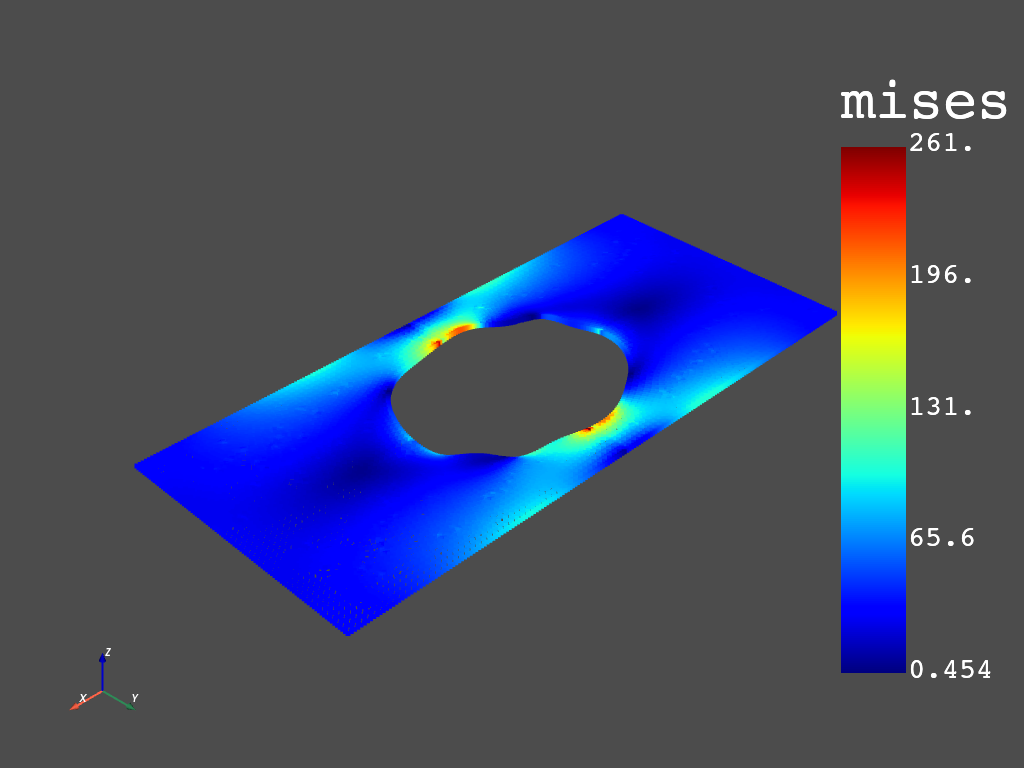

[(48.92329286329271, 48.92329286329271, 48.92329286329271),
 (0.0, 0.0, 0.0),
 (0.0, 0.0, 1.0)]

In [5]:
from pyvista import examples
pyLife_nodes = pyLife_mesh.groupby('node_id').mean()
mesh = pv.PolyData(pyLife_nodes[['x', 'y', 'z']].values)
mesh.point_arrays["mises"] = pyLife_nodes["mises"].values
mesh.plot(scalars="mises")

or using itk (for more information see here: https://pyvista-doc.readthedocs.io/en/latest/plotting/itk_plotting.html)

In [6]:
pl = pv.PlotterITK()
pl.add_mesh(mesh, scalars="mises", smooth_shading=True)
pl.show(True)

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

Viewer(geometries=[{'vtkClass': 'vtkPolyData', 'points': {'vtkClass': 'vtkPoints', 'name': '_points', 'numberO…

#### output to vmap

### ANSYS

In [7]:
result = pymapdl_reader.read_binary('beam.rst')
elem_df = pd.DataFrame(result.mesh.elem).iloc[:,10:]
elem_df["element_id"] = pd.DataFrame(result.mesh.elem).iloc[:,8]
index_mesh = pd.DataFrame(index=pd.MultiIndex.from_frame(
    pd.melt(elem_df, id_vars="element_id", value_name="node_id").drop("variable",axis=1)))
nnum, stress = result.nodal_stress(0)
ansys_mesh = pd.DataFrame(data=np.concatenate((result.mesh.nodes,stress), axis=1),
                          index=nnum,
                          columns=['x', 'y', 'z', 'S11', 'S22', 'S33', 'S12', 'S23', 'S13']).dropna()
ansys_mesh.index.name = "node_id"
ansys_df = index_mesh.join(ansys_mesh).dropna()
display(ansys_df)

,,x,y,z,S11,S22,S33,S12,S23,S13
element_id,node_id,,,,,,,,,
9686,5921,-4.500000,-0.6,0.500000,0.055999,-0.027743,-2.556435,0.365905,3.092182,-0.929771
9687,5921,-4.500000,-0.6,0.500000,0.055999,-0.027743,-2.556435,0.365905,3.092182,-0.929771
9688,5922,-4.500000,-0.2,0.500000,0.021350,-0.016056,-0.844268,0.742184,4.671668,-0.220989
9689,5923,-4.500000,0.2,0.500000,-0.021172,0.015592,0.844829,0.742229,4.671950,0.220545
9690,5924,-4.500000,0.6,0.500000,-0.055799,0.028506,2.555722,0.365712,3.092072,0.929897
...,...,...,...,...,...,...,...,...,...,...
9786,7303,0.512436,-1.0,8.215762,-3.163776,-0.007943,-27.196525,0.043157,0.088704,4.807310
9787,7294,0.101185,-0.2,7.991210,-1.011787,-0.076964,-4.099985,0.154397,4.653870,0.224506
9788,7295,0.101185,0.2,7.991210,1.011786,0.077210,4.099997,0.154386,4.653859,-0.224518


In [20]:
# calculate the stress gradient
ansys_df['mises'] = ansys_df.equistress.mises()

dtype('O')

In [26]:
ansys_df.loc[9686].index

Int64Index([5921, 11315, 11713, 12325, 7645, 11711, 11712, 12398], dtype='int64', name='node_id')

In [ ]:
grad = ansys_df.gradient.gradient_of('mises')
display(grad)

In [ ]:
# You can use the pyansys API or working directly with the pyLife dataframe as above
result.plot_principal_nodal_stress(0, 'SEQV')